In [2]:
from fl_puf.Utils.tabular_data_loader import prepare_tabular_data
from DPL.RegularizationLoss import RegularizationLoss
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch

In [3]:
test_nodes = sorted(ù
    [
        int(node)
        for node in [
            "15",
            "71",
            "0",
            "87",
            "19",
            "120",
            "85",
            "127",
            "32",
            "149",
            "38",
            "23",
            "126",
            "72",
            "7",
            "66",
            "2",
            "31",
            "128",
            "130",
            "89",
            "115",
            "131",
            "79",
            "36",
            "77",
            "81",
            "117",
            "140",
            "57",
            "53",
            "30",
            "139",
            "21",
            "138",
            "141",
            "142",
            "50",
            "78",
            "116",
            "12",
            "83",
            "56",
            "64",
            "24",
            "61",
            "92",
            "84",
            "34",
            "6",
        ]
    ]
)
test_nodes = [int(x) for x in test_nodes]

train_nodes = [x for x in range(150) if x not in test_nodes]

In [4]:
def get_disparity(client_data):
    clients_disparity = []
    client_names = []
    for client_name, client in enumerate(client_data):
        max_disparity = 0
        y = list(client["y"])
        z = list(client["z"])
        for target in [0, 1]:
            for sensitive_value in [0, 1]:
                max_disparity = max(
                    RegularizationLoss().compute_violation_with_argmax(
                        predictions_argmax=y,
                        sensitive_attribute_list=z,
                        current_target=target,
                        current_sensitive_feature=sensitive_value,
                    ),
                    max_disparity,
                )
        clients_disparity.append(max_disparity)
        client_names.append(client_name)
    return clients_disparity, client_names


def get_disparity_node(y, z):
    max_disparity = 0
    for target in [0, 1]:
        max_disparity = max(
            RegularizationLoss().compute_violation_with_argmax(
                predictions_argmax=list(y),
                sensitive_attribute_list=list(z),
                current_target=target,
                current_sensitive_feature=0,
            ),
            max_disparity,
        )
    return max_disparity


def find_disparity(groups_balance_factor, priv_balance_factor, folder_name=None, do_iid_split=False):
    fed_dir, client_data = prepare_tabular_data(
        dataset_path="../data/Tabular/dutch/",
        dataset_name="dutch",
        groups_balance_factor=groups_balance_factor,
        priv_balance_factor=priv_balance_factor,
        do_iid_split=do_iid_split,
    )
    clients_disparity, clients_name = get_disparity(client_data)
    # plot the disparity for each client
    print(
        f"Current setup groups_balance_factor={groups_balance_factor}, priv_balance_factor={priv_balance_factor}"
    )
    plt.figure(figsize=(20, 8))
    plt.bar(clients_name, clients_disparity)
    plt.xlabel("Client")
    plt.ylabel("Disparity")
    plt.title("Disparity per client")
    plt.tight_layout()
    if folder_name:
        plt.savefig(
            f"./experiments/{folder_name}/disparity_nodes_{groups_balance_factor}_{priv_balance_factor}.png"
        )
    else:
        plt.show()
    return client_data


def plot_disparity_test_nodes(
    disparities, folder_name, groups_balance_factor, priv_balance_factor
):
    # sort the nodes by disparity
    # disparities = {
    #     k: v for k, v in sorted(disparities.items(), key=lambda item: item[1])
    # }
    # disparities.values()

    x = list(disparities.keys())
    y = list(disparities.values())
    # plot the disparity for each client without using the x values as
    # ticks but only as a name
    plt.figure(figsize=(20, 8))
    plt.bar(range(len(y)), y)
    plt.xticks(range(len(x)), x)
    plt.xlabel("Client")
    plt.ylabel("Disparity")
    plt.title("Disparity per client (Test Nodes)")
    plt.tight_layout()
    plt.savefig(
        f"./experiments/{folder_name}/test_nodes_disparity_{groups_balance_factor}_{priv_balance_factor}.png"
    )


def plot_disparity_train_nodes(
    disparities_train, folder_name, groups_balance_factor, priv_balance_factor
):
    # sort the nodes by disparity
    # disparities = {
    #     k: v for k, v in sorted(disparities_train.items(), key=lambda item: item[1])
    # }
    disparities = disparities_train

    x = list(disparities.keys())
    y = list(disparities.values())
    # plot the disparity for each client without using the x values as
    # ticks but only as a name
    plt.figure(figsize=(20, 8))
    plt.bar(range(len(y)), y)
    plt.xticks(range(len(x)), x)
    plt.xlabel("Client")
    plt.ylabel("Disparity")
    plt.xticks(rotation=90)
    plt.title("Disparity per client (Train Nodes)")
    plt.tight_layout()
    plt.savefig(
        f"./experiments/{folder_name}/train_nodes_disparity_{groups_balance_factor}_{priv_balance_factor}.png"
    )

In [5]:
def plot_disparities(
    groups_balance_factor,
    priv_balance_factor,
    folder_name,
):
    client_data = find_disparity(
        folder_name=folder_name,
        groups_balance_factor=groups_balance_factor,
        priv_balance_factor=priv_balance_factor,
    )

    y_z = [
        [(int(y), int(z)) for y, z in zip(client["y"], client["z"])]
        for client in client_data
    ]

    disparities = {}
    for node in test_nodes:
        current_node = y_z[node]
        y = torch.tensor([y for y, z in current_node])
        z = torch.tensor([z for y, z in current_node])
        current_disparity = get_disparity_node(y, z)
        disparities[node] = current_disparity

    plot_disparity_test_nodes(
        disparities, folder_name, groups_balance_factor, priv_balance_factor
    )

    disparities_train = {}
    for node in train_nodes:
        current_node = y_z[node]
        y = torch.tensor([y for y, z in current_node])
        z = torch.tensor([z for y, z in current_node])
        current_disparity = get_disparity_node(y, z)
        disparities_train[node] = current_disparity

    plot_disparity_train_nodes(
        disparities_train, folder_name, groups_balance_factor, priv_balance_factor
    )

In [6]:
# possible_groups_balance_factor = [
#     0.5,
#     0.3,
#     0.6,
#     0.8,
#     0.9,
# ]
# possible_priv_balance_factor = [0.9, 0.9, 0.9, 0.9, 0.8]
# folder_names = ["dutch", "dutch_2", "dutch_3", "dutch_4", "dutch_5"]

In [7]:
# plot_disparities(0.3, 0.9, "dutch_2")

In [8]:
# for groups_balance_factor, priv_balance_factor, folder_name in zip(
#     possible_groups_balance_factor, possible_priv_balance_factor, folder_names
# ):
#     plot_disparities(groups_balance_factor, priv_balance_factor, folder_name)

# Distribution

In [9]:
# len(train_set)
# Sampled for training:  ['147', '124', '95', '3', '76', '11', '37', '65', '100', '5', '49', '108', '94', '148', '4', '110', '75', '59', '113', '144']
#  Sampled for training:  ['25', '112', '122', '10', '8', '42', '44', '60', '18', '17', '97', '47', '123', '111', '129', '145', '26', '93', '88', '102']
#  Sampled for training:  ['69', '22', '63', '45', '134', '98', '62', '105', '82', '90', '125', '68', '70', '58', '40', '73', '55', '96', '29', '133']
#  Sampled for training:  ['54', '86', '48', '13', '91', '146', '118', '27', '109', '119', '147', '124', '95', '3', '76', '11', '37', '65', '100', '5']

In [10]:
# train_set = [
#     "68",
#     "73",
#     "14",
#     "74",
#     "69",
#     "48",
#     "124",
#     "58",
#     "121",
#     "108",
#     "20",
#     "63",
#     "4",
#     "43",
#     "129",
#     "17",
#     "29",
#     "102",
#     "10",
#     "75",
#     "136",
#     "80",
#     "88",
#     "111",
#     "54",
#     "70",
#     "67",
#     "94",
#     "125",
#     "11",
#     "18",
#     "46",
#     "112",
#     "147",
#     "47",
#     "93",
#     "97",
#     "144",
#     "51",
#     "96",
#     "132",
#     "107",
#     "25",
#     "133",
#     "76",
#     "8",
#     "101",
#     "110",
#     "91",
#     "146",
#     "3",
#     "95",
#     "106",
#     "118",
#     "65",
#     "1",
#     "9",
#     "86",
#     "49",
#     "37",
#     "105",
#     "134",
#     "148",
#     "103",
#     "35",
#     "55",
#     "44",
#     "27",
#     "123",
#     "28",
# ]
# validation_set = [
#     "13",
#     "41",
#     "137",
#     "114",
#     "22",
#     "39",
#     "82",
#     "26",
#     "143",
#     "52",
#     "16",
#     "60",
#     "145",
#     "33",
#     "113",
#     "90",
#     "62",
#     "59",
#     "5",
#     "98",
#     "100",
#     "42",
#     "99",
#     "122",
#     "45",
#     "135",
#     "109",
#     "104",
#     "40",
#     "119",
# ]

In [11]:
# import torch
# from DPL.RegularizationLoss import RegularizationLoss

# disparities_train = {}
# for node_name in validation_set:
#     dataset = torch.load(f"../data/Tabular/dutch/federated/{node_name}/train.pt")
#     targets = dataset.targets
#     max_disparity_dataset = np.max(
#         [
#             RegularizationLoss().compute_violation_with_argmax(
#                 predictions_argmax=dataset.targets,
#                 sensitive_attribute_list=dataset.sensitive_features,
#                 current_target=target,
#                 current_sensitive_feature=sv,
#             )
#             for target in range(0, 1)
#             for sv in range(0, 1)
#         ]
#     )
#     disparities_train[node_name] = max_disparity_dataset

# # plot the disparity for each client without using the x values as
# # ticks but only as a name
# plt.figure(figsize=(20, 8))
# plt.bar(range(len(disparities_train)), list(disparities_train.values()))
# plt.xticks(range(len(disparities_train)), list(disparities_train.keys()))
# plt.xlabel("Client")
# plt.ylabel("Disparity")
# plt.xticks(rotation=90)
# plt.title("Disparity per client (Validation Nodes)")
# plt.tight_layout()
# plt.show()

In [12]:
# import torch
# from DPL.RegularizationLoss import RegularizationLoss

# disparities_train = {}
# for node_name in train_set:
#     dataset = torch.load(f"../data/Tabular/dutch/federated/{node_name}/train.pt")
#     targets = dataset.targets
#     max_disparity_dataset = np.max(
#         [
#             RegularizationLoss().compute_violation_with_argmax(
#                 predictions_argmax=dataset.targets,
#                 sensitive_attribute_list=dataset.sensitive_features,
#                 current_target=target,
#                 current_sensitive_feature=sv,
#             )
#             for target in range(0, 1)
#             for sv in range(0, 1)
#         ]
#     )
#     disparities_train[node_name] = max_disparity_dataset

# # plot the disparity for each client without using the x values as
# # ticks but only as a name
# plt.figure(figsize=(20, 8))
# plt.bar(range(len(disparities_train)), list(disparities_train.values()))
# plt.xticks(range(len(disparities_train)), list(disparities_train.keys()))
# plt.xlabel("Client")
# plt.ylabel("Disparity")
# plt.xticks(rotation=90)
# plt.title("Disparity per client (Train Nodes)")
# plt.tight_layout()
# plt.show()

# Test all the disparities

In [13]:
# for group_balance in np.arange(0.1, 1.0, 0.1):
#     for priv_balance in np.arange(0.5, 1.0, 0.1):
#         find_disparity(
#             groups_balance_factor=group_balance, priv_balance_factor=priv_balance
#         )

Using ['sex_binary'] as sensitive feature(s).
Data shapes: x=(60420, 10), y=(60420,), z=(60420, 2)
shapes before shuffle: (60420, 10), (60420,), (60420, 2)
Number of priv clients: 120, unpriv clients: 30
Total number of priv samples: 30273 (0.6729 positive label), unpriv samples: 30147 (0.3744 positive label)
Priv clients size: 227+25, unpriv clients size: 101+904
Current setup groups_balance_factor=0.8, priv_balance_factor=0.9


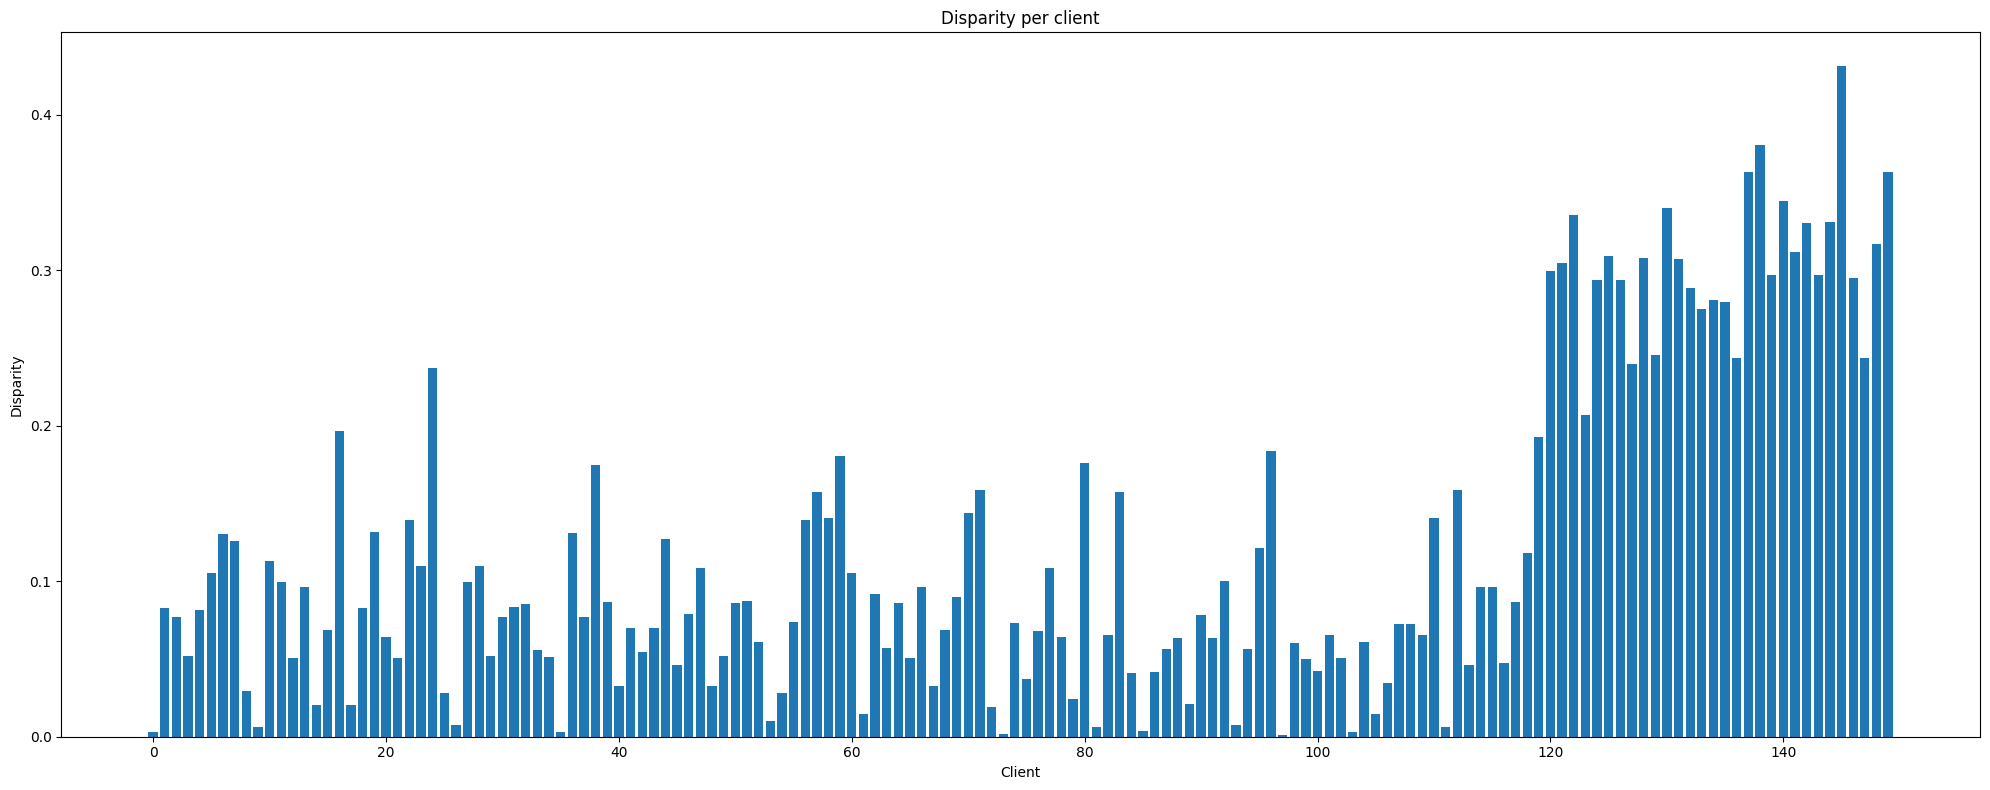

In [15]:
client_data = find_disparity(
            groups_balance_factor=0.8, priv_balance_factor=0.9
        ) 